In [1]:
%pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import sys
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

# Import project-specific internal modules
from preprocessor import DataPreprocessor
from src.plots import PlotGenerator
from src import config
from config import RUN_CONFIGURATION, EMOTION_STATES, NLP_CONFIG, SENTIMENT_MODEL_EXPORT_PATH_RAW, \
    SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, EMOTION_VARIATIONS_PATH, NEGATION_PATTERNS_PATH, \
    HYPERPARAMETERS, RANDOM_STATE, PREDICTION_MODEL_EXPORT_PATH, TOPIC_MODEL_EXPORT_PATH, \
    is_step_enabled

# Unsupervised learning imports
from clustering import ClusteringAnalysis

# Supervised learning imports

# NLP imports
from src.sentiment_analysis import SentimentAnalysisModel
from src.emotion_postprocessor import EmotionPostProcessor
from src.clinical_notes_prediction import ClinicalNotesNoShowPredictor
from clinical_topic_model import ClinicalTopicModel

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Create an instance of the preprocessing and plotting classes
preprocessor = DataPreprocessor(config)
plotter = PlotGenerator(style='whitegrid', palette='viridis', figsize=(10, 6))

<a id='dataset'></a>
# 3. Dataset:
---

In [3]:
if is_step_enabled('dataload'):
    df = preprocessor.load_data(config.DATASET_PATH)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

'shape:'

(110527, 17)

'columns:'

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a..."
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ..."
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ..."
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...


,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


<a id='datacleaning'></a>
# 4. Data Cleaning and Pre-processing:
---

In [4]:
if is_step_enabled('data_preprocess'):
    df = preprocessor.preprocess_data(df)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

[preprocessing] Starting preprocessing...
Initial shape of the dataset: (110527, 17)
Initial columns in the dataset: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')
Dropping unnecessary columns...
Remaining columns: Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason'],
      dtype='object')
Converting date columns to datetime...
Handling missing values...
Adding emotional state columns...
Emotional state columns added: ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Final shape of the dataset: (110527, 21)
Final columns in the dataset: Index(['Gender

'shape:'

(110527, 21)

'columns:'

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful',
       'fear'],
      dtype='object')

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason,WaitDays,anxiety,stress,confusion,hopeful,fear
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,0,0,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a...",-1,0,1,1,0,1
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,0,0,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ...",-1,0,1,1,0,0
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,0,0,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ...",-1,1,0,1,0,0
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,0,0,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...,-1,0,0,0,0,0
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,0,0,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...,-1,0,0,0,0,1


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays,anxiety,stress,confusion,hopeful,fear
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702,0.491979,0.603273,0.532594,0.106336,0.426412
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996,0.499938,0.489221,0.498939,0.308269,0.494557
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id='exploratory'></a>
# 5. Exploratory Data Analysis:
---

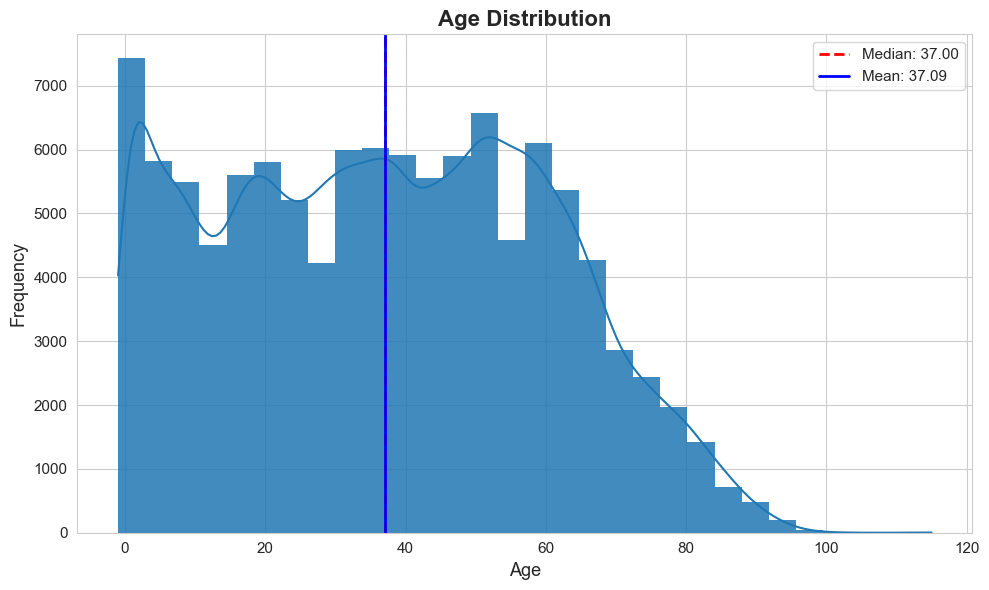

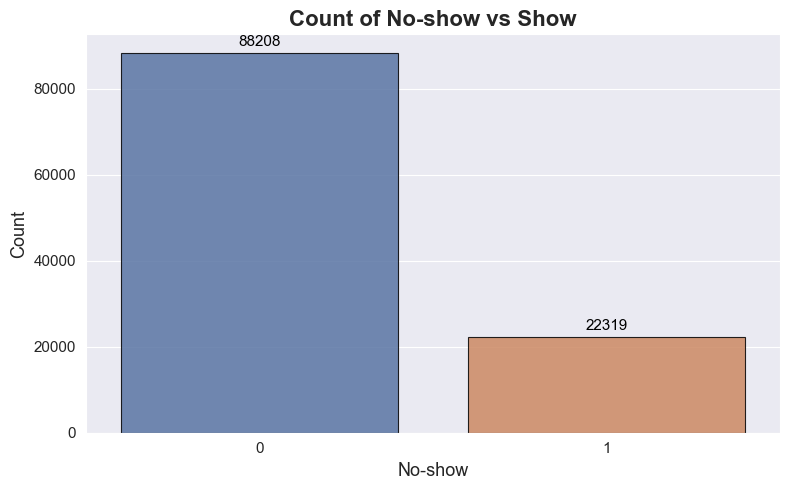

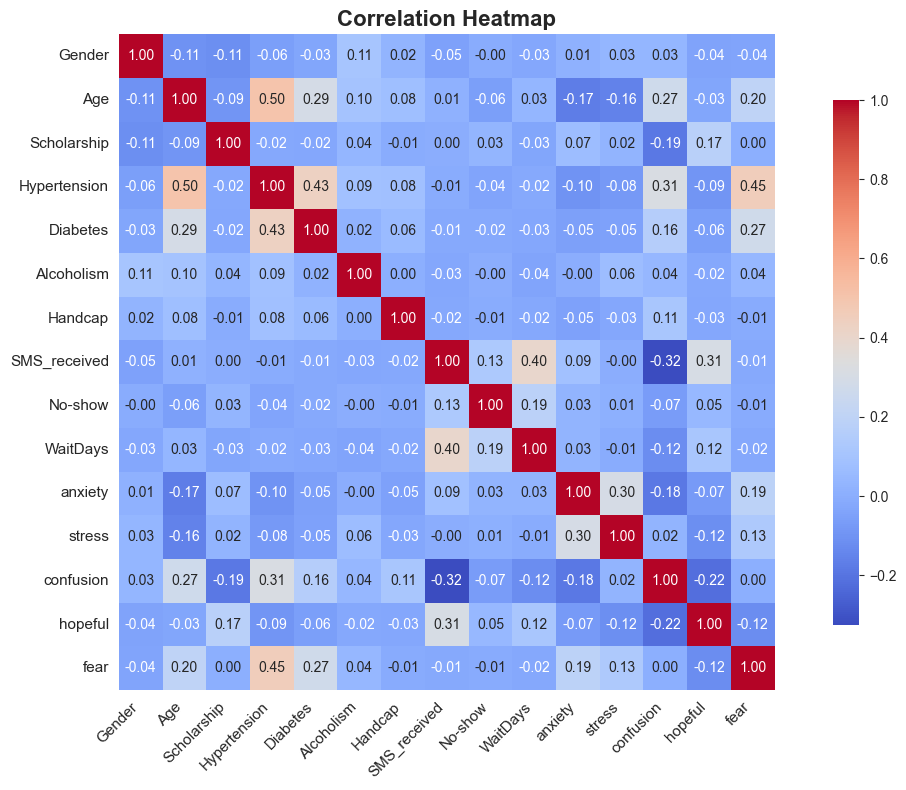

In [5]:
if is_step_enabled('eda'):
    # Distribution of Age - Using class-based approach
    plotter.plot_histplot(
        data=df,
        column='Age',
        bins=30,
        kde=True,
        title='Age Distribution',
        xlabel='Age',
        ylabel='Frequency',
        figsize=(10, 6)
    )

    # Countplot of No-show vs Show
    plotter.plot_countplot(
        data=df,
        column='No-show',
        title='Count of No-show vs Show',
        xlabel='No-show',
        ylabel='Count',
        figsize=(8, 5)
    )

    # Correlation heatmap 
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()
    plotter.plot_heatmap(
        data=correlation_matrix,
        title='Correlation Heatmap',
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        figsize=(12, 8)
    )

- The age distribution peaks in early childhood and declines steadily with age, showing most patients are under 60.
- The distribution is fairly symmetric with a slight right skew due to fewer older patients.
- The plot shows that most patients attended their appointments (No-show=0), while a smaller group missed them (No-show=1).
- This indicates a class imbalance, which is important to consider for predictive modeling.
- The correlation heatmap shows weak to moderate relationships among most features, with few strong correlations (e.g., Age-Hypertension, Hypertension-Diabetes).
- Most variables are largely independent, suggesting minimal multicollinearity and diverse feature contributions for modeling.

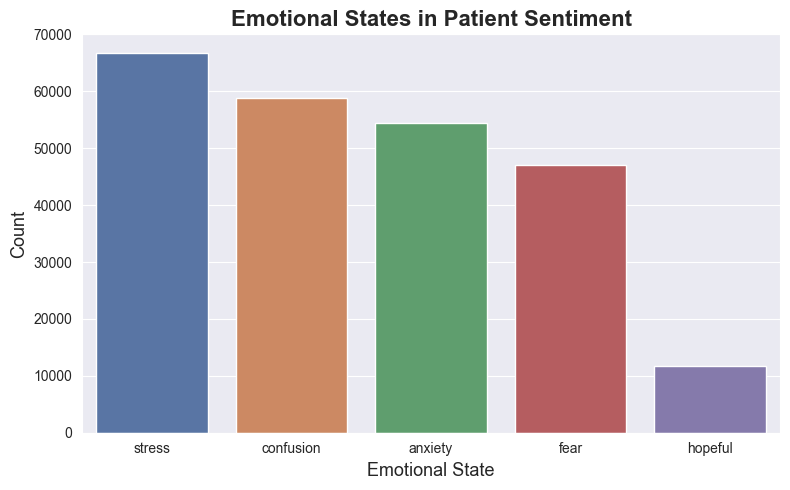

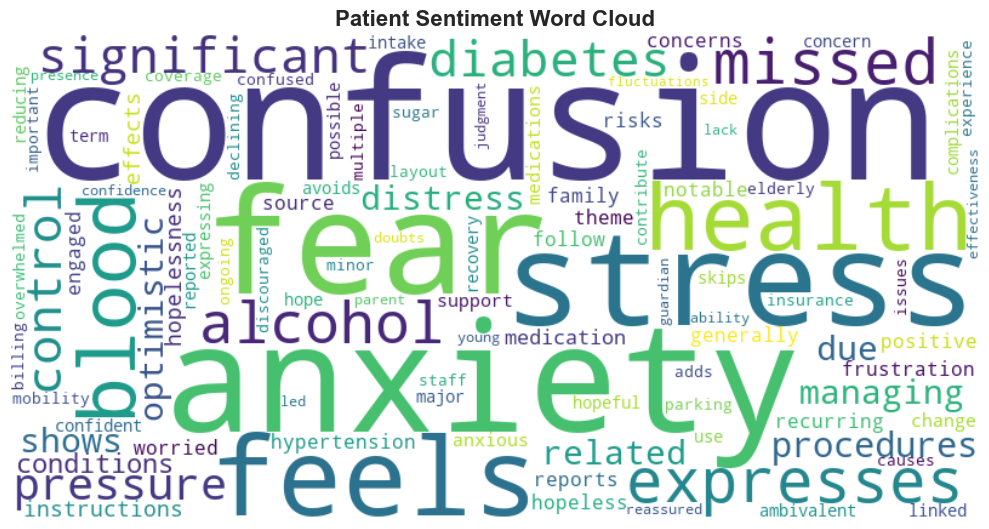

Total unique words after filtering: 161
Top 10 most frequent words: {'confusion': 77779, 'anxiety': 62099, 'fear': 57339, 'stress': 55610, 'feels': 54774, 'health': 50047, 'blood': 35628, 'expresses': 34563, 'missed': 33931, 'alcohol': 29663}


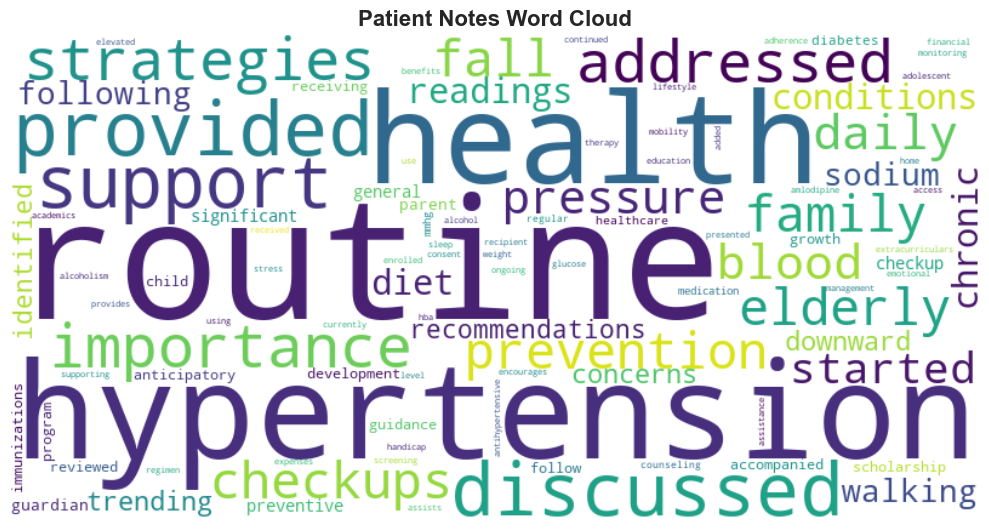

Total unique words after filtering: 480
Top 10 most frequent words: {'routine': 75106, 'hypertension': 69899, 'health': 62876, 'provided': 61365, 'discussed': 56894, 'support': 54154, 'importance': 45468, 'strategies': 43443, 'addressed': 43435, 'prevention': 43424}


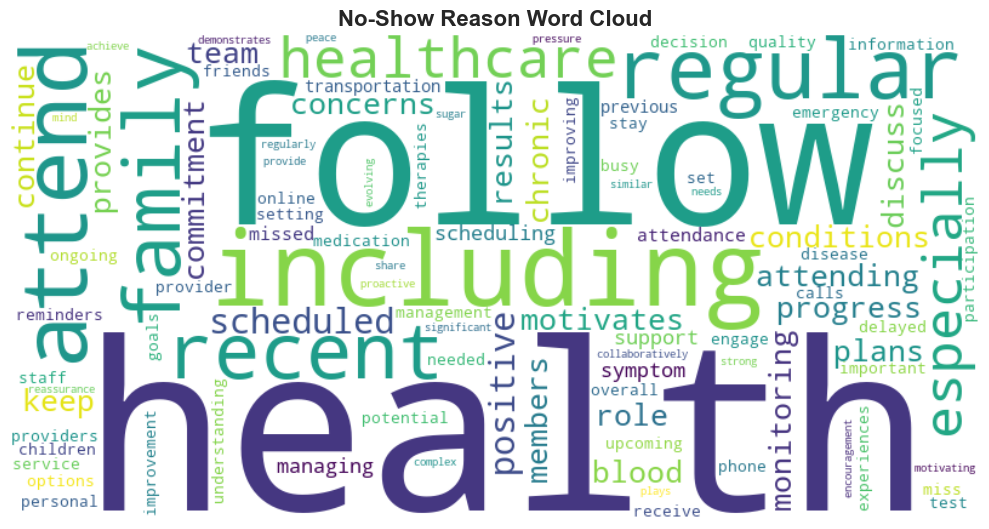

Total unique words after filtering: 477
Top 10 most frequent words: {'health': 35477, 'follow': 21074, 'including': 19948, 'attend': 15422, 'regular': 15302, 'family': 13660, 'recent': 13186, 'healthcare': 11945, 'especially': 11621, 'scheduled': 11592}


In [6]:
if is_step_enabled('eda'):
    # Plot emotional states as a bar plot - Using class method
    plotter.plot_emotional_states_bar(df)

    # Plot word clouds for PatientSentiment, PatientNotes, and NoShowReason
    plotter.plot_text_wordcloud_custom_stopwords(df['PatientSentiment'], title='Patient Sentiment Word Cloud')
    plotter.plot_text_wordcloud_custom_stopwords(df['PatientNotes'], title='Patient Notes Word Cloud')
    plotter.plot_text_wordcloud_custom_stopwords(df['NoShowReason'], title='No-Show Reason Word Cloud')

- The bar plot shows that stress, confusion, and anxiety are the most common emotional states among patients, with stress being the highest.
- Hopeful sentiment is much less frequent, indicating a predominance of negative emotions in patient sentiment data.
- The word cloud highlights that "confusion," "anxiety," "fear," and "stress" are the most frequently expressed sentiments among patients. This suggests that negative emotions dominate patient feedback, indicating areas for targeted intervention.
- The word cloud shows that "routine", "hypertension", "health", and "provided" are the most frequently mentioned terms in patient notes, highlighting a focus on regular care and chronic condition management.
- The word cloud shows that "health", "follow", "attend", and "including" are the most common reasons cited for no-shows, highlighting the importance of health-related factors and follow-up in patient attendance.

<a id='modelselection'></a>
# 6. Model Selection:
---

This project employs a combination of supervised, unsupervised, and natural language processing (NLP) models to predict and analyze patient appointment no-shows. 

### Supervised Learning Models

**Logistic Regression**  
Logistic Regression is a statistical model used for binary classification tasks. It estimates the probability that a given input belongs to a particular category by applying the logistic (sigmoid) function to a linear combination of input features (Hosmer et al., 2013).  
*Justification:* Logistic Regression is interpretable and effective for baseline binary classification, making it suitable for predicting no-show events based on structured patient data.

**Random Forest**  
Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of their predictions (Breiman, 2001). It handles non-linear relationships and interactions between features well.  
*Justification:* Random Forest is robust to overfitting and can capture complex patterns in the data, which is valuable for healthcare datasets with mixed feature types.

**Gradient Boosting (XGBoost)**  
XGBoost is an optimized implementation of gradient boosting machines, which sequentially build decision trees to correct errors made by previous trees (Chen & Guestrin, 2016).  
*Justification:* XGBoost is known for its high predictive performance and efficiency, making it suitable for structured data with potential feature interactions.

### Unsupervised Learning Models

**Principal Component Analysis (PCA)**  
PCA is a dimensionality reduction technique that transforms correlated features into a set of linearly uncorrelated components, capturing the maximum variance in the data (Jolliffe & Cadima, 2016).  
*Justification:* PCA helps visualize and reduce the complexity of high-dimensional patient data, facilitating clustering and interpretation.

**K-Means Clustering**  
K-Means is an unsupervised algorithm that partitions data into k clusters by minimizing the within-cluster sum of squares (MacQueen, 1967).  
*Justification:* K-Means is efficient for grouping patients with similar profiles, aiding in understanding patient segments and tailoring interventions.

**Gaussian Mixture Model (GMM)**  
GMM is a probabilistic model that assumes data is generated from a mixture of several Gaussian distributions (Reynolds, 2009).  
*Justification:* GMM provides soft clustering and can model clusters of different shapes and sizes, which is useful for heterogeneous patient populations.

### Natural Language Processing (NLP) Models

**Sentiment Analysis Model**  
A custom neural network-based sentiment analysis model is used to detect emotional states in patient notes, leveraging domain-specific vocabularies and context-aware rules (Cambria et al., 2017).  
*Justification:* Understanding patient sentiment provides insights into behavioral factors influencing no-shows, complementing structured data analysis.

**Topic Modeling (LDA with MedSpaCy Preprocessing)**  
Latent Dirichlet Allocation (LDA) is a generative probabilistic model for discovering topics in text corpora (Blei et al., 2003). MedSpaCy is used for clinical concept extraction and preprocessing.  
*Justification:* Topic modeling uncovers underlying themes and reasons for no-shows in clinical notes, supporting qualitative analysis.

<a id='modelselectionsupervised'></a>
## 6.1 Supervised Learning - Patient Show/No Show Prediction:
---

This use case focuses exclusively on **Supervised Learning for Patient Show/No Show Prediction**. Missed medical appointments, or "no-shows," can disrupt healthcare operations and negatively impact patient outcomes. To address this, the project leverages supervised machine learning models to predict whether a patient will attend their scheduled appointment.

**Algorithm and Approach:**
- **Supervised Learning Models:** Logistic Regression, Random Forest, and XGBoost are employed to predict appointment attendance using structured data such as demographics, medical history, and appointment details.
- **Feature Engineering:** Relevant features are selected and engineered to improve model performance, including patient age, prior no-show history, comorbidities, and appointment lead time.
- **Model Evaluation:** The models are evaluated using metrics like accuracy, precision, recall, and ROC-AUC to ensure reliable predictions.

By accurately identifying patients at risk of missing appointments, this approach enables healthcare providers to implement targeted interventions, optimize scheduling, and improve overall patient care.

<a id='logisticregression'></a>
### 6.1.1 Logistic Regression:
---

<a id='randomforest'></a>
### 6.1.2 Random Forest:
---

<a id='xgboost'></a>
### 6.1.3 Gradient Boosting-XGBoost:
---

<a id='supervisedfeature'></a>
### 6.1.4 Feature Engineering:
---

In [7]:
# Feature selection for modeling
selected_features = [
    'WaitDays', 'SMS_received', 'Age', 'Alcoholism', 
    'Scholarship', 'Gender', 'Diabetes', 'Handcap'
]

X = df[selected_features].copy()
y = df['No-show']

print(f"\nFeatures shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"No-show rate: {y.mean():.1%}")


Features shape: (110527, 8)
Target distribution: {0: 88208, 1: 22319}
No-show rate: 20.2%


<a id='supervisedtraining'></a>
### 6.1.5 Model Training:
---

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Class imbalance analysis
class_distribution = y_train.value_counts(normalize=True)
no_show_rate = class_distribution[1]
class_ratio = (y_train == 0).sum() / (y_train == 1).sum()

print("CLASS IMBALANCE ANALYSIS")
print("=" * 40)
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"No-show rate: {no_show_rate:.1%}")
print(f"Class ratio (Show:No-show): {class_ratio:.1f}:1")
print(f"Imbalance severity: {'High' if class_ratio > 3 else 'Moderate'}")

# Calculate class weights for balancing
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
scale_pos_weight = class_weights[0] / class_weights[1]

print(f"\nClass weights: {class_weight_dict}")
print(f"XGBoost scale_pos_weight: {scale_pos_weight:.2f}")

CLASS IMBALANCE ANALYSIS
Training samples: 88,421
Test samples: 22,106
No-show rate: 20.2%
Class ratio (Show:No-show): 4.0:1
Imbalance severity: High

Class weights: {0: 0.6265127681886461, 1: 2.4760851302156257}
XGBoost scale_pos_weight: 0.25


In [ ]:
# Train baseline models
print("TRAINING BASELINE MODELS")
print("=" * 40)

# Initialize models with class balancing
base_models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000
    ),
    'Random Forest': RandomForestClassifier(
        class_weight='balanced', random_state=RANDOM_STATE, n_estimators=100
    ),
    'XGBoost': XGBClassifier(
        scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE,
        eval_metric='logloss', use_label_encoder=False
    )
}

# Train and evaluate baseline models
base_results = {}
for name, model in base_models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    base_results[name] = {
        'F1': f1, 'Precision': precision, 'Recall': recall,
        'Accuracy': accuracy, 'ROC_AUC': roc_auc
    }
    
    print(f"{name}:")
    print(f"  F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")
    print(f"  Accuracy: {accuracy:.3f}, ROC AUC: {roc_auc:.3f}")

# Create baseline summary
base_summary = pd.DataFrame(base_results).T
display(base_summary.round(3))

TRAINING BASELINE MODELS
Logistic Regression:
  F1: 0.411, Precision: 0.321, Recall: 0.572
  Accuracy: 0.669, ROC AUC: 0.669
Logistic Regression:
  F1: 0.411, Precision: 0.321, Recall: 0.572
  Accuracy: 0.669, ROC AUC: 0.669
Random Forest:
  F1: 0.361, Precision: 0.311, Recall: 0.430
  Accuracy: 0.693, ROC AUC: 0.635
Random Forest:
  F1: 0.361, Precision: 0.311, Recall: 0.430
  Accuracy: 0.693, ROC AUC: 0.635
XGBoost:
  F1: 0.003, Precision: 0.857, Recall: 0.001
  Accuracy: 0.798, ROC AUC: 0.728
XGBoost:
  F1: 0.003, Precision: 0.857, Recall: 0.001
  Accuracy: 0.798, ROC AUC: 0.728


,F1,Precision,Recall,Accuracy,ROC_AUC
Logistic Regression,0.411,0.321,0.572,0.669,0.669
Random Forest,0.361,0.311,0.430,0.693,0.635
XGBoost,0.003,0.857,0.001,0.798,0.728


<a id='supervisedhyper'></a>
### 6.1.6 Hyper Parameter Tuning:
---

In [ ]:
print("ADVANCED HYPERPARAMETER TUNING")
print("=" * 50)

# 1. Logistic Regression - Advanced grid
print("\n1. Optimizing Logistic Regression...")
lr_param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}],
    'max_iter': [1000, 2000]
}

lr_random = RandomizedSearchCV(
    LogisticRegression(random_state=RANDOM_STATE),
    lr_param_grid, n_iter=50, cv=5, scoring='f1',
    n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
lr_random.fit(X_train, y_train)
lr_tuned = lr_random.best_estimator_
print(f"Best LR F1: {lr_random.best_score_:.3f}")
print(f"Best LR params: {lr_random.best_params_}")

# 2. Random Forest - Advanced grid
print("\n2. Optimizing Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    rf_param_grid, n_iter=50, cv=5, scoring='f1',
    n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
rf_random.fit(X_train, y_train)
rf_tuned = rf_random.best_estimator_
print(f"Best RF F1: {rf_random.best_score_:.3f}")
print(f"Best RF params: {rf_random.best_params_}")

# 3. XGBoost - Two-stage optimization
print("\n3. Optimizing XGBoost (Two-stage approach)...")

# Stage 1: Broad search
xgb_param_grid_stage1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [scale_pos_weight * 0.5, scale_pos_weight, scale_pos_weight * 1.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.5, 1, 1.5],
    'gamma': [0, 0.1, 0.5]
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                  random_state=RANDOM_STATE, tree_method='hist'),
    xgb_param_grid_stage1, n_iter=75, cv=5, scoring='f1',
    n_jobs=1, random_state=RANDOM_STATE, verbose=1
)
xgb_random.fit(X_train, y_train)
best_params_stage1 = xgb_random.best_params_
print(f"Stage 1 best F1: {xgb_random.best_score_:.3f}")

# Stage 2: Fine-tuning around best parameters
print("Stage 2: Fine-tuning...")
refined_grid = {
    'n_estimators': [max(50, best_params_stage1['n_estimators'] - 50), 
                    best_params_stage1['n_estimators'], 
                    best_params_stage1['n_estimators'] + 50],
    'max_depth': [max(2, best_params_stage1['max_depth'] - 1),
                  best_params_stage1['max_depth'],
                  min(8, best_params_stage1['max_depth'] + 1)],
    'learning_rate': [max(0.01, best_params_stage1['learning_rate'] - 0.02),
                     best_params_stage1['learning_rate'],
                     min(0.3, best_params_stage1['learning_rate'] + 0.02)]
}
# Keep other best parameters
for param in ['subsample', 'colsample_bytree', 'scale_pos_weight', 'reg_alpha', 'reg_lambda', 'gamma']:
    refined_grid[param] = [best_params_stage1[param]]

xgb_fine = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                  random_state=RANDOM_STATE, tree_method='hist'),
    refined_grid, cv=5, scoring='f1', n_jobs=1, verbose=1
)
xgb_fine.fit(X_train, y_train)
xgb_tuned = xgb_fine.best_estimator_
print(f"Final best F1: {xgb_fine.best_score_:.3f}")
print(f"Final best params: {xgb_fine.best_params_}")

# Store tuned models
tuned_models = {
    'Logistic Regression (Tuned)': lr_tuned,
    'Random Forest (Tuned)': rf_tuned,
    'XGBoost (Tuned)': xgb_tuned
}

print("\n✓ Hyperparameter tuning completed!")

ADVANCED HYPERPARAMETER TUNING

1. Optimizing Logistic Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best LR F1: 0.408
Best LR params: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'class_weight': {0: 1, 1: 4}, 'C': 0.01}

2. Optimizing Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RF F1: 0.444
Best RF params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.7, 'max_depth': 7, 'class_weight': 'balanced_subsample'}

3. Optimizing XGBoost (Two-stage approach)...
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Stage 1 best F1: 0.007
Stage 2: Fine-tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Final best F1: 0.018
Final best params: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.16999999999999998, 'max_depth': 7, 'n_estimators': 250, 'reg_alpha': 0.01, 'reg_lambda': 1.5, 'scale_pos_weight': 0.3795383045659383, 'subsample':

In [ ]:
print("SMOTE + THRESHOLD OPTIMIZATION")
print("=" * 40)

# Find best performing model from tuning
tuning_scores = {
    'LR': lr_random.best_score_,
    'RF': rf_random.best_score_,
    'XGB': xgb_fine.best_score_
}
best_model_type = max(tuning_scores, key=tuning_scores.get)
print(f"Best model from tuning: {best_model_type} (F1: {tuning_scores[best_model_type]:.3f})")

# Select best base model
if best_model_type == 'XGB':
    best_base_model = XGBClassifier(**xgb_fine.best_params_)
elif best_model_type == 'RF':
    best_base_model = RandomForestClassifier(**rf_random.best_params_)
else:
    best_base_model = LogisticRegression(**lr_random.best_params_)

# Create SMOTE pipeline
smote_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE, k_neighbors=3)),
    ('classifier', best_base_model)
])

# Train SMOTE model
smote_pipeline.fit(X_train, y_train)
smote_proba = smote_pipeline.predict_proba(X_test)[:, 1]

# Threshold optimization
print("\nOptimizing prediction threshold...")
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred_thresh = (smote_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    
    threshold_results.append({
        'Threshold': threshold,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    })

# Find optimal threshold
threshold_df = pd.DataFrame(threshold_results)
optimal_idx = threshold_df['F1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'Threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'F1']

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Optimal F1 score: {optimal_f1:.3f}")

# Create optimized model class
class OptimizedSMOTEModel:
    def __init__(self, pipeline, threshold):
        self.pipeline = pipeline
        self.threshold = threshold
    
    def predict(self, X):
        proba = self.pipeline.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)
    
    def predict_proba(self, X):
        return self.pipeline.predict_proba(X)

optimized_smote_model = OptimizedSMOTEModel(smote_pipeline, optimal_threshold)

# Add to tuned models
tuned_models[f'{best_model_type} (SMOTE + Threshold)'] = optimized_smote_model

print("\n✓ SMOTE + Threshold optimization completed!")

SMOTE + THRESHOLD OPTIMIZATION
Best model from tuning: RF (F1: 0.444)

Optimizing prediction threshold...
Optimal threshold: 0.40
Optimal F1 score: 0.440

✓ SMOTE + Threshold optimization completed!


<a id='supervisedevaluation'></a>
### 6.1.7 Model Evaluation:
---

In [ ]:
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 50)

# Evaluate all models
final_results = {}

# Combine baseline and tuned models
all_models = {**base_models, **tuned_models}

for name, model in all_models.items():
    try:
        # Make predictions
        y_pred = model.predict(X_test)
        
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'pipeline'):
            y_proba = model.pipeline.predict_proba(X_test)[:, 1]
        else:
            y_proba = None
        
        # Calculate metrics
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 0.0
        
        final_results[name] = {
            'F1': f1,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'ROC_AUC': roc_auc
        }
        
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        final_results[name] = {'Error': str(e)}

# Create results DataFrame
results_df = pd.DataFrame(final_results).T
results_df = results_df[results_df.columns[~results_df.columns.isin(['Error'])]]

# Sort by F1 score
results_df = results_df.sort_values('F1', ascending=False)

print("\nFINAL MODEL PERFORMANCE COMPARISON:")
display(results_df.round(3))

# Identify best model
best_model_name = results_df.index[0]
best_f1_score = results_df.loc[best_model_name, 'F1']

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   F1 Score: {best_f1_score:.3f}")
print(f"   Precision: {results_df.loc[best_model_name, 'Precision']:.3f}")
print(f"   Recall: {results_df.loc[best_model_name, 'Recall']:.3f}")
print(f"   ROC AUC: {results_df.loc[best_model_name, 'ROC_AUC']:.3f}")

COMPREHENSIVE MODEL EVALUATION

FINAL MODEL PERFORMANCE COMPARISON:


,F1,Precision,Recall,Accuracy,ROC_AUC
Random Forest (Tuned),0.448,0.307,0.829,0.587,0.730
RF (SMOTE + Threshold),0.440,0.291,0.898,0.538,0.716
Logistic Regression (Tuned),0.413,0.321,0.580,0.668,0.670
Logistic Regression,0.411,0.321,0.572,0.669,0.669
Random Forest,0.361,0.311,0.430,0.693,0.635
XGBoost (Tuned),0.015,0.576,0.008,0.798,0.723
XGBoost,0.003,0.857,0.001,0.798,0.728



🏆 BEST PERFORMING MODEL: Random Forest (Tuned)
   F1 Score: 0.448
   Precision: 0.307
   Recall: 0.829
   ROC AUC: 0.730


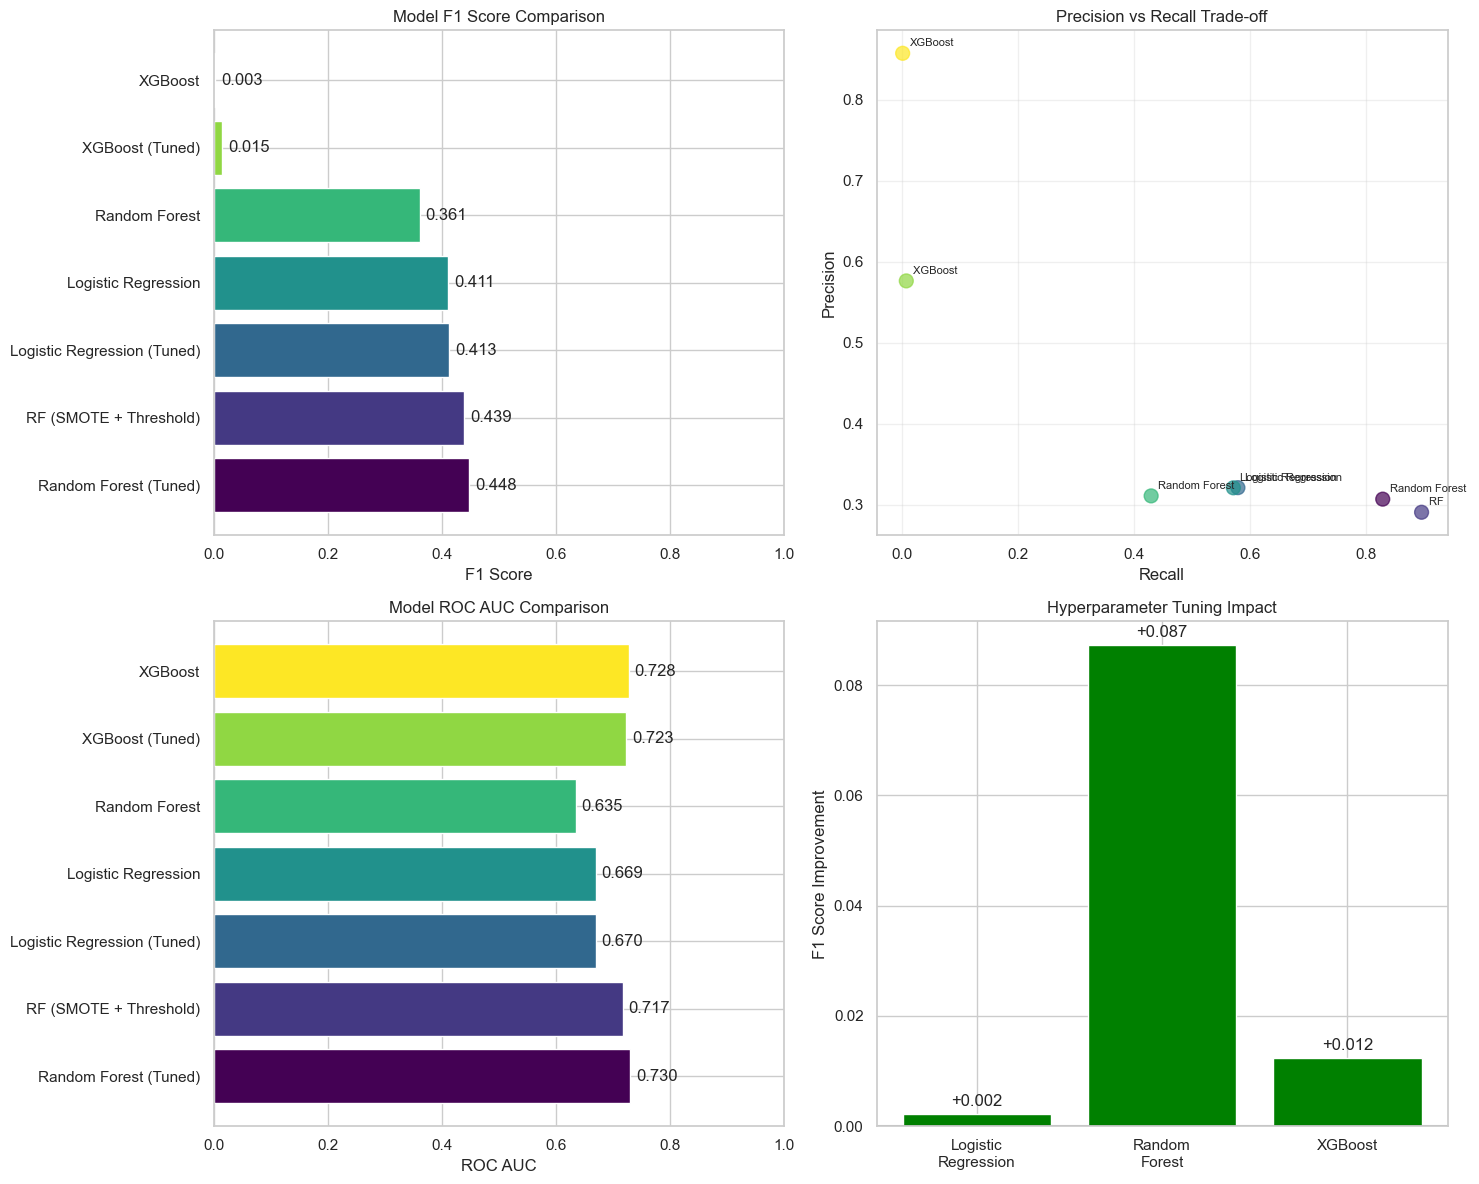

In [ ]:
# Performance comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# F1 Score comparison
models = results_df.index
f1_scores = results_df['F1']
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

bars1 = ax1.barh(models, f1_scores, color=colors)
ax1.set_xlabel('F1 Score')
ax1.set_title('Model F1 Score Comparison')
ax1.set_xlim(0, 1)
for i, v in enumerate(f1_scores):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center')

# Precision vs Recall
precision_scores = results_df['Precision']
recall_scores = results_df['Recall']
scatter = ax2.scatter(recall_scores, precision_scores, c=range(len(models)), 
                     cmap='viridis', s=100, alpha=0.7)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision vs Recall Trade-off')
ax2.grid(True, alpha=0.3)
for i, model in enumerate(models):
    ax2.annotate(model.split('(')[0], (recall_scores[i], precision_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# ROC AUC comparison
roc_scores = results_df['ROC_AUC']
bars3 = ax3.barh(models, roc_scores, color=colors)
ax3.set_xlabel('ROC AUC')
ax3.set_title('Model ROC AUC Comparison')
ax3.set_xlim(0, 1)
for i, v in enumerate(roc_scores):
    ax3.text(v + 0.01, i, f'{v:.3f}', va='center')

# Improvement analysis
baseline_models = ['Logistic Regression', 'Random Forest', 'XGBoost']
tuned_models_list = ['Logistic Regression (Tuned)', 'Random Forest (Tuned)', 'XGBoost (Tuned)']

improvements = []
model_types = []
for baseline, tuned in zip(baseline_models, tuned_models_list):
    if baseline in results_df.index and tuned in results_df.index:
        improvement = results_df.loc[tuned, 'F1'] - results_df.loc[baseline, 'F1']
        improvements.append(improvement)
        model_types.append(baseline.replace(' ', '\n'))

bars4 = ax4.bar(model_types, improvements, color=['green' if x > 0 else 'red' for x in improvements])
ax4.set_ylabel('F1 Score Improvement')
ax4.set_title('Hyperparameter Tuning Impact')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
for i, v in enumerate(improvements):
    ax4.text(i, v + 0.001, f'{v:+.3f}', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.show()

<a id='supervisedanalysis'></a>
### 6.1.8 Model Analysis:
---

In [ ]:
print("BUSINESS IMPACT ANALYSIS")
print("=" * 40)

# Business scenario parameters
total_patients = len(y_test)
actual_no_shows = sum(y_test)
no_show_cost = 150  # Cost per no-show
intervention_cost = 25  # Cost per intervention
intervention_success_rate = 0.25  # 25% success rate

# Best model metrics
best_results = results_df.iloc[0]
precision = best_results['Precision']
recall = best_results['Recall']
f1 = best_results['F1']

# Calculate business impact
predicted_no_shows = int(actual_no_shows / precision) if precision > 0 else 0
true_positives = int(predicted_no_shows * precision)
prevented_no_shows = int(true_positives * intervention_success_rate)

# Cost calculations
baseline_cost = actual_no_shows * no_show_cost
intervention_cost_total = predicted_no_shows * intervention_cost
prevented_cost = prevented_no_shows * no_show_cost
net_benefit = prevented_cost - intervention_cost_total
roi = (net_benefit / intervention_cost_total * 100) if intervention_cost_total > 0 else 0

print(f"\n📊 BUSINESS SCENARIO ANALYSIS:")
print(f"Total Test Patients: {total_patients:,}")
print(f"Actual No-Shows: {actual_no_shows:,} ({actual_no_shows/total_patients:.1%})")
print(f"\n🎯 MODEL PERFORMANCE:")
print(f"Best Model: {best_model_name}")
print(f"F1 Score: {f1:.3f}")
print(f"Precision: {precision:.3f} (Accuracy of predictions)")
print(f"Recall: {recall:.3f} (% of no-shows caught)")

print(f"\n💼 BUSINESS IMPACT:")
print(f"Patients Flagged for Intervention: {predicted_no_shows:,}")
print(f"True No-Shows Identified: {true_positives:,}")
print(f"No-Shows Prevented (25% success): {prevented_no_shows:,}")
print(f"Detection Rate: {true_positives/actual_no_shows:.1%} of all no-shows")

print(f"\n💰 FINANCIAL ANALYSIS:")
print(f"Baseline Cost (no intervention): ${baseline_cost:,}")
print(f"Intervention Cost: ${intervention_cost_total:,}")
print(f"Cost Savings from Prevention: ${prevented_cost:,}")
print(f"Net Benefit: ${net_benefit:,}")
print(f"ROI: {roi:.1f}%")

# Annual projection
annual_factor = 365 / len(y_test) * total_patients  # Rough annualization
annual_benefit = int(net_benefit * annual_factor)
print(f"\n📅 PROJECTED ANNUAL BENEFIT: ${annual_benefit:,}")

# Recommendations
print(f"\n🚀 RECOMMENDATIONS:")
if roi > 100:
    print("✅ IMPLEMENT: High ROI justifies deployment")
elif roi > 50:
    print("✅ IMPLEMENT: Moderate ROI with good business case")
else:
    print("⚠️  OPTIMIZE: Consider improving model or intervention strategy")

print("✅ Focus on high-probability predictions for better precision")
print("✅ Develop effective intervention strategies")
print("✅ Monitor model performance and retrain regularly")
print("✅ Consider A/B testing to validate intervention effectiveness")

BUSINESS IMPACT ANALYSIS

📊 BUSINESS SCENARIO ANALYSIS:
Total Test Patients: 22,106
Actual No-Shows: 4,464 (20.2%)

🎯 MODEL PERFORMANCE:
Best Model: Random Forest (Tuned)
F1 Score: 0.448
Precision: 0.307 (Accuracy of predictions)
Recall: 0.829 (% of no-shows caught)

💼 BUSINESS IMPACT:
Patients Flagged for Intervention: 14,542
True No-Shows Identified: 4,463
No-Shows Prevented (25% success): 1,115
Detection Rate: 100.0% of all no-shows

💰 FINANCIAL ANALYSIS:
Baseline Cost (no intervention): $669,600
Intervention Cost: $363,550
Cost Savings from Prevention: $167,250
Net Benefit: $-196,300
ROI: -54.0%

📅 PROJECTED ANNUAL BENEFIT: $-71,649,500

🚀 RECOMMENDATIONS:
⚠️  OPTIMIZE: Consider improving model or intervention strategy
✅ Focus on high-probability predictions for better precision
✅ Develop effective intervention strategies
✅ Monitor model performance and retrain regularly
✅ Consider A/B testing to validate intervention effectiveness


<a id='supervisedconclusion'></a>
### 6.1.7 Conclusion:
---